## Creating of web application in Dash Plotly to display vol surface data

We get the following web application where there are:

* 3d graph to display vol surface and 

* 2d heatmap to show the difference of vol surface compared to the previous day

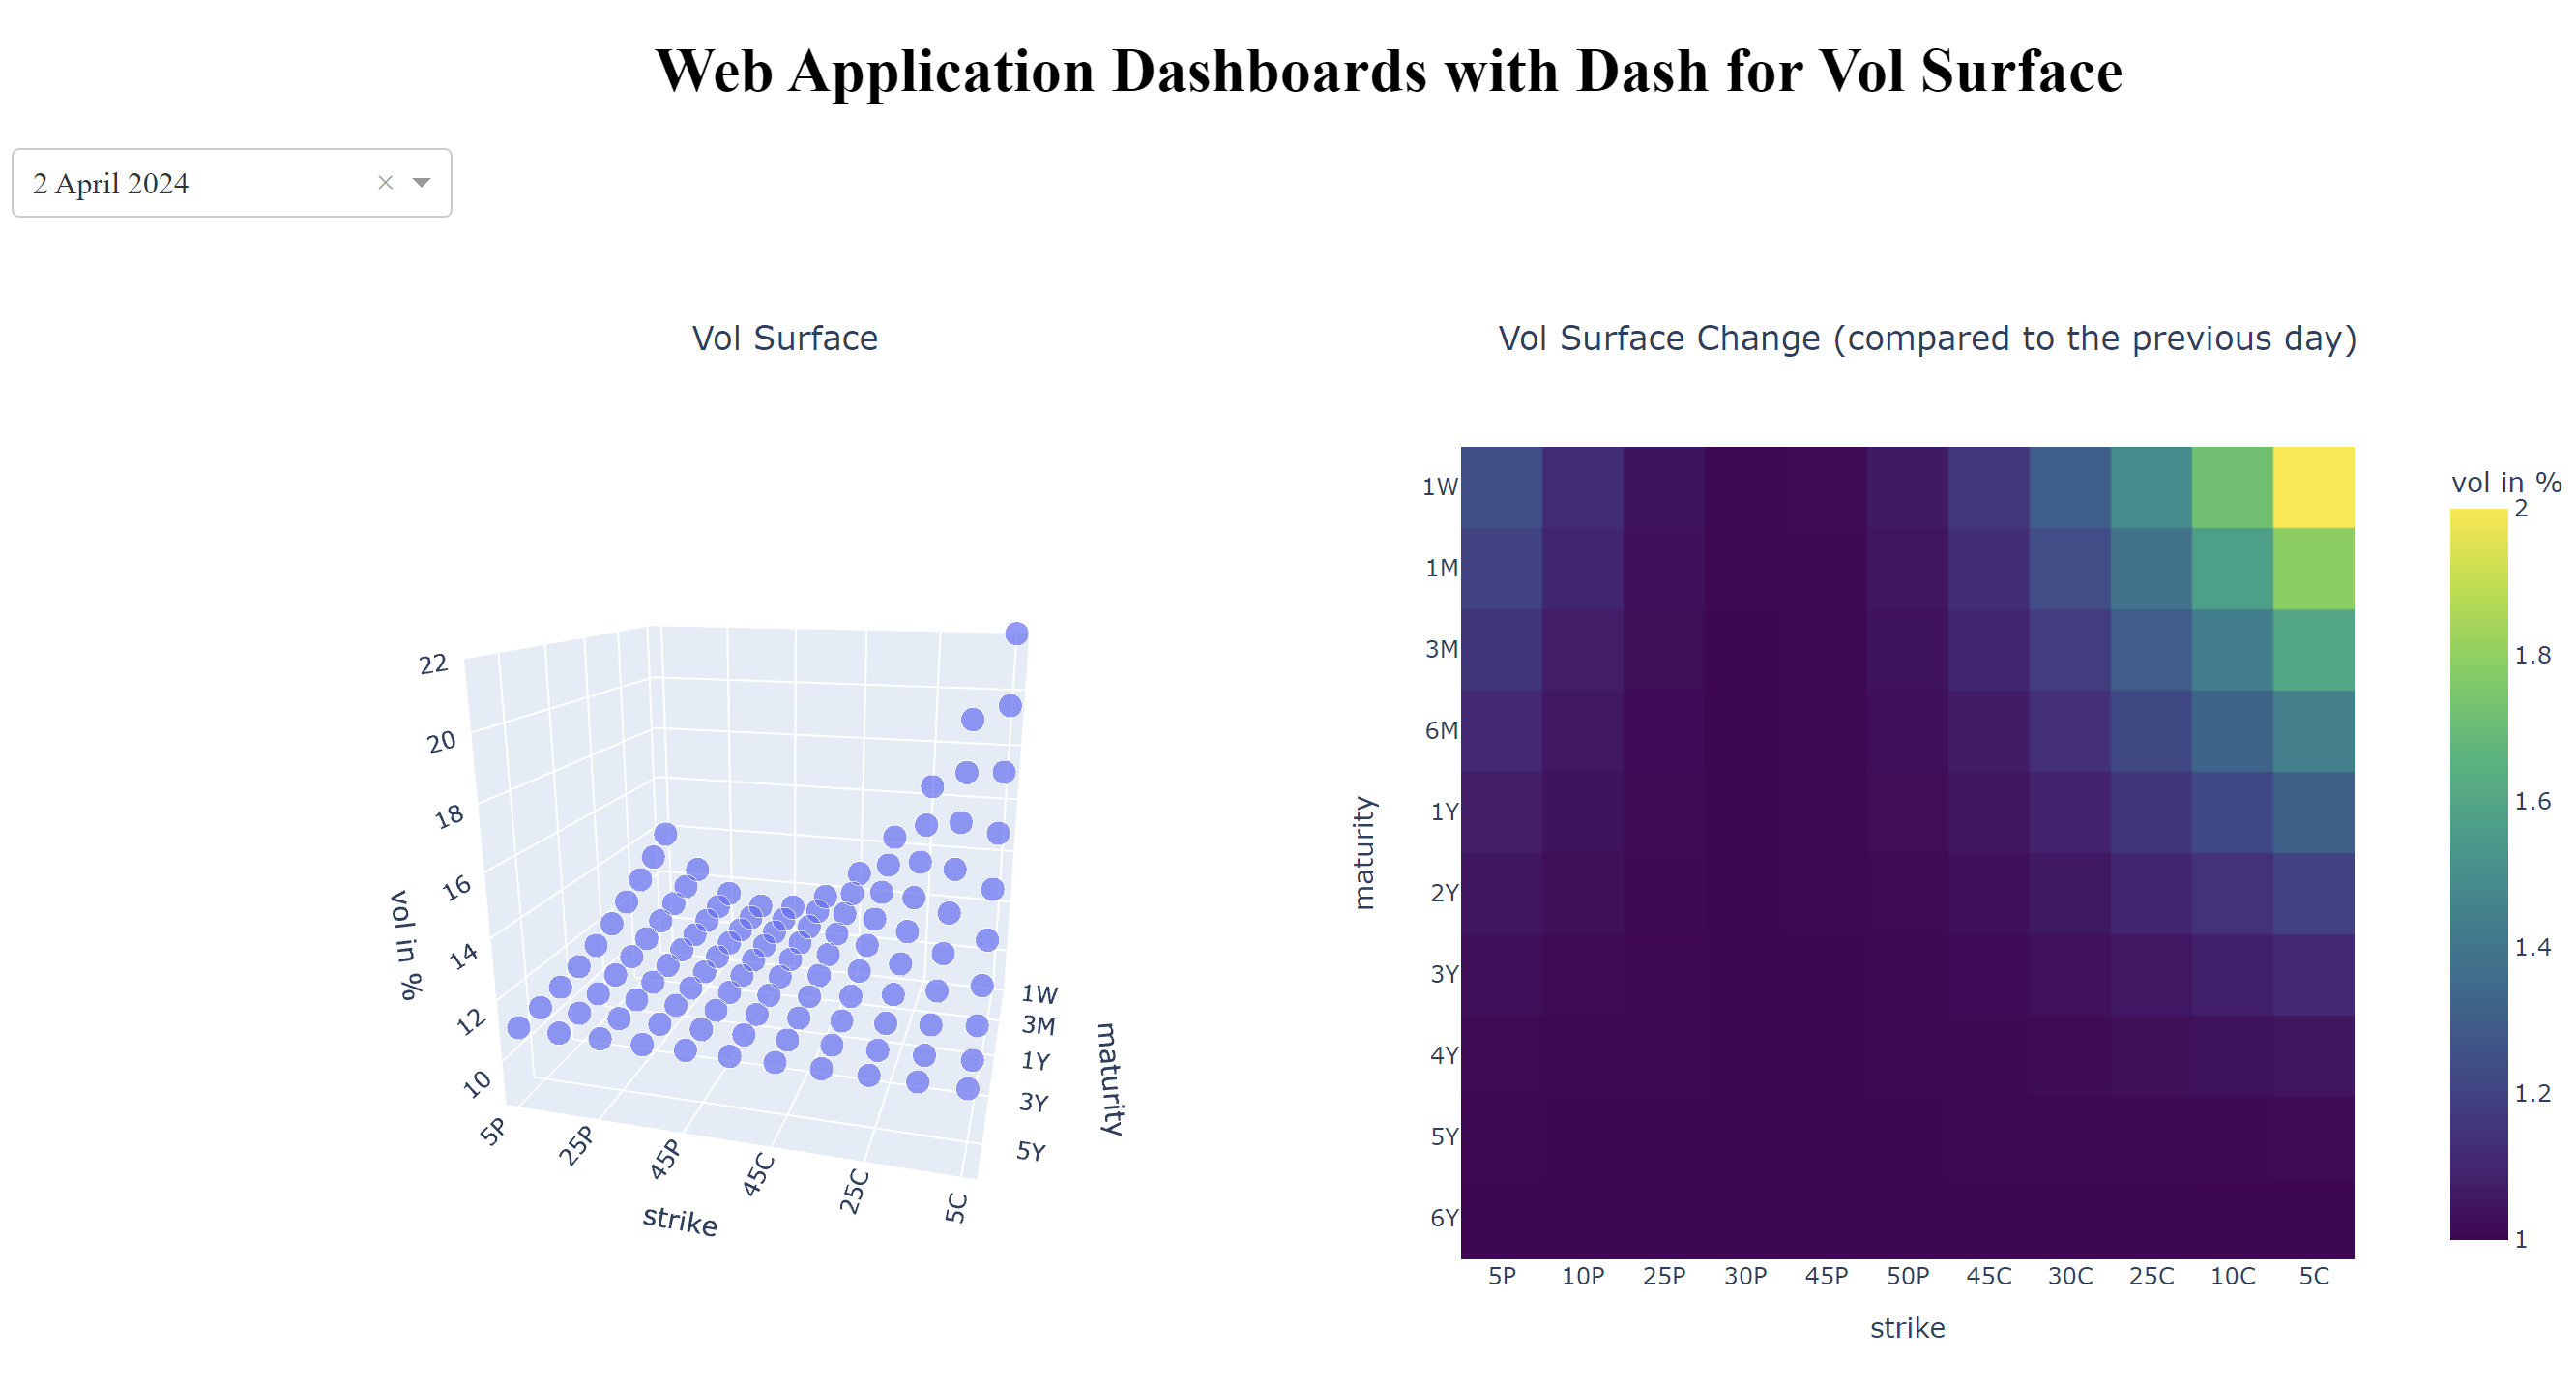

In [12]:
from IPython.display import Image
Image("picture_of_web_app.png", width = 800) # insert image

In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

# all possible strikes from the lowest ones to largest ones
STRIKE_LABEL_ORDER = ['5P', '10P', '25P', '30P', '45P', '50P', '45C', '30C', '25C', '10C', '5C']
# all possible maturities ordered by number of days
MATURITY_LABEL_ORDER = ['1D', '1W', '2W', '3W', '1M', '3M', '6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y']
# all dates for which we have data
DATES = ['1 April 2024', '2 April 2024', '3 April 2024', '4 April 2024', '5 April 2024']


# ------------------
# Preprocessing of the data
df = pd.read_csv("vol_surface_.csv")
# find min and max values to create a graph with fixed values on vol axis
vol_min = df['vol'].min()
vol_max = df['vol'].max()

# sort our strikes
strikes = np.unique(df['strike'])
strike_dict = {value: index for index, value in enumerate(STRIKE_LABEL_ORDER)}
strikes = sorted(strikes, key=lambda x: strike_dict[x]) # Sort strikes using the indices from STRIKE_LABEL_ORDER

# sort our maturities
maturities = np.unique(df['maturity'])
maturity_dict = {value: index for index, value in enumerate(MATURITY_LABEL_ORDER)}
maturities = sorted(maturities, key=lambda x: maturity_dict[x]) # Sort strikes using the indices from MATURITY_LABEL_ORDER

# sort dataframe based on date, then strike, then maturity
df['strike'] = pd.Categorical(df['strike'], categories=strikes, ordered=True)
df['maturity'] = pd.Categorical(df['maturity'], categories=maturities, ordered=True)
df = df.sort_values(by=['date', 'maturity', 'strike'])


# ------------------------------------------------------------------------------
# App layout
app = Dash(__name__)

app.layout = html.Div([

    html.H1("Web Application Dashboards with Dash for Vol Surface", style={'text-align': 'center'}),

    dcc.Dropdown(id="slct_date",
                 options=[
                     {"label": '2 April 2024', "value": '2 April 2024'},
                     {"label": '3 April 2024', "value": '3 April 2024'},
                     {"label": '4 April 2024', "value": '4 April 2024'},
                     {"label": '5 April 2024', "value": '5 April 2024'}],
                 multi=False,
                 value='2 April 2024',
                 style={'width': "40%"}
                 ),

    html.Br(),

    dcc.Graph(id='vol_surface', figure={}, style={'width': '45%', 'height': '400px', 'display': 'inline-block'}),

    dcc.Graph(id='vol_surf_chg_heatmap', figure={}, style={'width': '45%', 'height': '400px', 'display': 'inline-block'})

])

# ------------------------------------------------------------------------------
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output(component_id='vol_surface', component_property='figure')],  # we put figure to vol_surface object of the app
    [Output(component_id='vol_surf_chg_heatmap', component_property='figure')],  
    [Input(component_id='slct_date', component_property='value')]  # 
)

def update_ui(slct_date):  # we put here 1 input with slct_date=value from Input of the callback
    print(slct_date, type(slct_date)) # printing to track the changes

    data = df[df['date'] == slct_date]

    Z = data['vol'].values
    X_mesh, Y_mesh = np.meshgrid(strikes[::-1], maturities)  # reverse strikes to have strikes from left to right increasing
    Z_mesh = Z.reshape(X_mesh.shape)
    Z_mesh = np.array([row[::-1] for row in Z_mesh])  # because we reversed strikes 2 lines above

    # Draw a surface
    fig1 = px.scatter_3d(
    x=X_mesh.flatten(),
    y=Y_mesh.flatten(),
    z=Z_mesh.flatten(),
    labels=dict(x="strike", y="maturity", z="vol in %"),
    title="Vol Surface",
    size=np.linspace(5,5,110),
    range_z=[vol_min, vol_max],
    width=800,
    height=600
    )
    # Fix the camera angle
    fig1.update_layout(title=dict(x=0.5),
                       scene=dict(
                                 camera=dict(
                                            eye=dict(x=-0.6, y=2.2, z=0.7)
                                            )
                                 )
    )
    
    slct_date_idx = DATES.index(slct_date)
    prev_date = DATES[slct_date_idx - 1]
    data_old = df[df['date'] == prev_date]
    Z_old = data_old['vol'].values
    Z_chg_mesh = (Z - Z_old).reshape(X_mesh.shape)
    fig2 = px.imshow(
        Z_chg_mesh,
        labels=dict(x="strike", y="maturity", color="vol in %"),
        x=strikes,
        y=maturities,
        title="Vol Surface Change (compared to the previous day)",
        width=700,
        height=600,
        color_continuous_scale='Viridis'
    )
    fig2.update_layout(title=dict(x=0.5))  # title in the center

    return fig1, fig2  # callback has 2 outputs (if 1 output, we need to use [] )


# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server(debug=True)

2 April 2024 <class 'str'>
3 April 2024 <class 'str'>
2 April 2024 <class 'str'>
2 April 2024 <class 'str'>
